## Introduction

In this notebook, we will demonstrate how to use DendroTweaks as a standalone Python package.

# Imports

In [1]:
import sys
sys.path.append('app')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Creating a model

We will start by importing and instantiating the `CellModel` class

In [3]:
from model.model import CellModel

INFO       - cells.py - load_mechanisms : Loaded mod files from "app/model/mechanisms/mod/Synapses/"
INFO       - cells.py - reset_neuron : Resetting NEURON


In [4]:
model = CellModel(path_to_model='app/model/')

# Creating a cell


First let's explore the part of the interface responsible for creating a cell. We begin by creating a cell from the morphology file `"Park_2019.swc"`:

In [5]:
ls app/model/swc

Allen_L5.swc                    Park_2019.swc       smith_from_neuromorpho.swc
ball-and-stick.swc              point.swc           SST_Allen_full.swc
E_6_14_smooth_smaller_diam.swc  Poirazi_2003.swc
Hay_2011.asc                    Smith_2013_cat.swc


In [6]:
model.create_cell(swc_file="app/model/swc/Park_2019.swc")

Now the cell can be accessed as an attribute of our model. The cell class represent a NEURON cell object. It has acces to NEURON sections.

In [7]:
type(model.cell.dend[0])

nrn.Section

We must specify spatial discretization by using the `d_lambda` parameter.

In [8]:
model.cell.set_geom_nseg(d_lambda=0.1)

## Adding biophysical mechanisms

Next, we can add biophysical mechanisms to our model.

In DendroTweaks, values of a given biophysical parameter are set for groups of NEURON segments. The user must first select a group of segments. This can be easily done using the lasso mouse tool of the Graph plot in the GUI, but here we'll manually group the segments. We can utilize the `Group` class to assign a distribution function, represented by a callable `Distribution` class, to a selected set of segments.

In [9]:
somatic = [seg for sec in model.cell.soma for seg in sec]

basal = [seg for sec in model.cell.dend for seg in sec if sec in model.cell.dend]
axonal = [seg for sec in model.cell.axon for seg in sec]
basal = basal + axonal
apical = [seg for sec in model.cell.apic for seg in sec]
dendritic = basal + apical

dendritic_thin = [seg for sec in model.cell.dend + model.cell.apic
                  for seg in sec if seg.diam <= 0.8]
dendritic_thick = [seg for sec in model.cell.dend + model.cell.apic
                   for seg in sec if seg.diam > 0.8]

proximal_apical = [seg for sec in model.cell.apic
                   for seg in sec if model.cell.distance_from_soma(seg) <= 260]
distal_apical = [seg for sec in model.cell.apic
                 for seg in sec if model.cell.distance_from_soma(seg) > 260]

We will first add passive properties such as membrane capacitance.

In [10]:
model.add_capacitance()

By default, the capacitance has a group that encompasses all segments and assigns a uniform distribution with a value of 1 μF. We'll update the value of this group to 2 μF and create a new group only for the somatic segments, assigning it a value of 1 μF. Note that the groups act as layers. The later group will overwrite the segments even if they belonged to an earlier created group. This is beneficial because if we remove the group, we'll return to the state before we added it.

In [11]:
from model.mechanisms.distributions import Distribution

model.capacitance.groups[0].distribution = Distribution('uniform', value=2)

In [12]:
model.capacitance.add_group(somatic,
                            param_name='cm',
                            distribution=Distribution('uniform', value=1))

In [13]:
model.capacitance.groups

[Group 0_cm uniform, Group 1_cm uniform]

We'll next add ion channels. The channels will be added as membrane mechanisms from `.mod` files. DendroTweaks will compile the files and insert the channels for us.

In [14]:
ls app/model/mechanisms/mod

Hay_Ca_HVA/    Hay_SK_E2/    Park_Km/       Poirazi_kad/       Poirazi_nap/
Hay_Ca_LVAst/  Hay_SKv3_1/   Park_Kv/       Poirazi_kap/       Poirazi_Na_soma/
Hay_Ih/        Ih_Allen/     Park_Na/       Poirazi_kca/       Poirazi_somacar/
Hay_Im/        Leak/         Poirazi_cal/   Poirazi_Kdr_dend/  Synapses/
Hay_K_Pst/     Park_Ca_HVA/  Poirazi_calH/  Poirazi_Kdr_soma/
Hay_K_Tst/     Park_Ca_LVA/  Poirazi_car/   Poirazi_km/
Hay_Nap_Et2/   Park_Ka/      Poirazi_cat/   Poirazi_mykca/
Hay_NaTa_t/    Park_KCa/     Poirazi_h/     Poirazi_Na_dend/


In [15]:
model.add_channel(mod_name = 'Leak', recompile=True)
model.add_channel(mod_name = 'Park_Na', recompile=True)
model.add_channel(mod_name='Park_Kv', recompile=True)
model.add_channel(mod_name='Park_Km', recompile=True)
model.add_channel(mod_name='Park_Ka', recompile=True)
model.add_channel(mod_name='Park_Ca_HVA', recompile=True)
model.add_channel(mod_name='Park_Ca_LVA', recompile=True)
model.add_channel(mod_name='Park_KCa', recompile=True)
model.add_ca_dynamics(mod_name='Park_cadyn')

/home/roman/anaconda3/envs/chapy/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO       - cells.py - load_mechanisms : Recompiled mod files in "app/model/mechanisms/mod/Leak/"
INFO       - cells.py - load_mechanisms : Loaded mod files from "app/model/mechanisms/mod/Leak/"
INFO       - model.py - add_channel : Added channel "Leak" with suffix "leak"





/home/roman/Documents/code/DendroTweaks/app/model/mechanisms/mod/Leak
Mod files: "./Leak.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special
Wrote app/model/mechanisms/collection/Park_Na.py
/home/roman/Documents/code/DendroTweaks/app/model/mechanisms/mod/Park_Na
Mod files: "./Park_Na.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so


/home/roman/anaconda3/envs/chapy/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO       - cells.py - load_mechanisms : Recompiled mod files in "app/model/mechanisms/mod/Park_Na/"
INFO       - cells.py - load_mechanisms : Loaded mod files from "app/model/mechanisms/mod/Park_Na/"
INFO       - model.py - add_channel : Added channel "Park_Na" with suffix "na"





Successfully created x86_64/special
Wrote app/model/mechanisms/collection/Park_Kv.py


/home/roman/anaconda3/envs/chapy/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO       - cells.py - load_mechanisms : Recompiled mod files in "app/model/mechanisms/mod/Park_Kv/"
INFO       - cells.py - load_mechanisms : Loaded mod files from "app/model/mechanisms/mod/Park_Kv/"
INFO       - model.py - add_channel : Added channel "Park_Kv" with suffix "kv"





/home/roman/Documents/code/DendroTweaks/app/model/mechanisms/mod/Park_Kv
Mod files: "./Park_Kv.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


/home/roman/anaconda3/envs/chapy/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


Wrote app/model/mechanisms/collection/Park_Km.py
/home/roman/Documents/code/DendroTweaks/app/model/mechanisms/mod/Park_Km
Mod files: "./Park_Km.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so


INFO       - cells.py - load_mechanisms : Recompiled mod files in "app/model/mechanisms/mod/Park_Km/"
INFO       - cells.py - load_mechanisms : Loaded mod files from "app/model/mechanisms/mod/Park_Km/"
INFO       - model.py - add_channel : Added channel "Park_Km" with suffix "km"





Successfully created x86_64/special
Wrote app/model/mechanisms/collection/Park_Ka.py
/home/roman/Documents/code/DendroTweaks/app/model/mechanisms/mod/Park_Ka
Mod files: "./Park_Ka.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so


/home/roman/anaconda3/envs/chapy/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO       - cells.py - load_mechanisms : Recompiled mod files in "app/model/mechanisms/mod/Park_Ka/"
INFO       - cells.py - load_mechanisms : Loaded mod files from "app/model/mechanisms/mod/Park_Ka/"
INFO       - model.py - add_channel : Added channel "Park_Ka" with suffix "ka"





Successfully created x86_64/special
Wrote app/model/mechanisms/collection/Park_Ca_HVA.py


/home/roman/anaconda3/envs/chapy/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO       - cells.py - load_mechanisms : Recompiled mod files in "app/model/mechanisms/mod/Park_Ca_HVA/"
INFO       - cells.py - load_mechanisms : Loaded mod files from "app/model/mechanisms/mod/Park_Ca_HVA/"
INFO       - model.py - add_channel : Added channel "Park_Ca_HVA" with suffix "cahva"





/home/roman/Documents/code/DendroTweaks/app/model/mechanisms/mod/Park_Ca_HVA
Mod files: "./Park_Ca_HVA.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special
Wrote app/model/mechanisms/collection/Park_Ca_LVA.py
/home/roman/Documents/code/DendroTweaks/app/model/mechanisms/mod/Park_Ca_LVA
Mod files: "./Park_Ca_LVA.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so


/home/roman/anaconda3/envs/chapy/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO       - cells.py - load_mechanisms : Recompiled mod files in "app/model/mechanisms/mod/Park_Ca_LVA/"
INFO       - cells.py - load_mechanisms : Loaded mod files from "app/model/mechanisms/mod/Park_Ca_LVA/"
INFO       - model.py - add_channel : Added channel "Park_Ca_LVA" with suffix "calva"





Successfully created x86_64/special
Wrote app/model/mechanisms/collection/Park_KCa.py


/home/roman/anaconda3/envs/chapy/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO       - cells.py - load_mechanisms : Recompiled mod files in "app/model/mechanisms/mod/Park_KCa/"
INFO       - cells.py - load_mechanisms : Loaded mod files from "app/model/mechanisms/mod/Park_KCa/"
INFO       - model.py - add_channel : Added channel "Park_KCa" with suffix "kca"





/home/roman/Documents/code/DendroTweaks/app/model/mechanisms/mod/Park_KCa
Mod files: "./Park_KCa.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


/home/roman/anaconda3/envs/chapy/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO       - cells.py - load_mechanisms : Recompiled mod files in "app/model/mechanisms/mod_cadyn/Park_cadyn/"
INFO       - cells.py - load_mechanisms : Loaded mod files from "app/model/mechanisms/mod_cadyn/Park_cadyn/"


/home/roman/Documents/code/DendroTweaks/app/model/mechanisms/mod_cadyn/Park_cadyn
Mod files: "./Park_cadyn.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


After adding the channels to the model, we now want to specify distributions for channel conductances. Again, what we need for that is a group of segments, the parameter name, and the distribution function. Note that for uniform distribution, it's important to pass the keyword argument `value`. For more complex distributions, specific keywords should be used, e.g., `slope` and `intercept` for a linear distribution.

In [16]:
model.channels['Leak'].add_group(dendritic + somatic,
                                param_name='gbar_leak',
                                distribution=Distribution('uniform', value=0.0000909))

In [17]:
model.channels['Park_Na'].add_group(somatic,
                                    param_name='gbar_na',
                                    distribution=Distribution('uniform', value=0.0505))

model.channels['Park_Na'].add_group(dendritic,
                                    param_name='gbar_na',
                                    distribution=Distribution('uniform', value=0.0303))                                    

model.channels['Park_Kv'].add_group(somatic,
                                    param_name='gbar_kv',
                                    distribution=Distribution('uniform', value=0.005))

model.channels['Park_Kv'].add_group(dendritic,
                                    param_name='gbar_kv', 
                                    distribution=Distribution('uniform', value=0.000_15))


model.channels['Park_Km'].add_group(somatic,
                                    param_name='gbar_km', 
                                    distribution=Distribution('uniform', value=0.000_2794))

model.channels['Park_Km'].add_group(dendritic,
                                    param_name='gbar_km', 
                                    distribution=Distribution('uniform', value=0.000_127))


model.channels['Park_Ka'].add_group(somatic,
                                    param_name='gbar_ka', 
                                    distribution=Distribution('uniform', value=0.0054))

model.channels['Park_Ka'].add_group(dendritic_thin,
                                    param_name='gbar_ka', 
                                    distribution=Distribution('uniform', value=0.108))

model.channels['Park_Ka'].add_group(dendritic_thick,
                                    param_name='gbar_ka', 
                                    distribution=Distribution('uniform', value=0.0108))

model.channels['Park_KCa'].add_group(somatic,
                                    param_name='gbar_kca', 
                                    distribution=Distribution('uniform', value=0.000_21))

model.channels['Park_KCa'].add_group(dendritic,
                                    param_name='gbar_kca', 
                                    distribution=Distribution('uniform', value=0.000_21))

model.channels['Park_Ca_HVA'].add_group(somatic,
                                        param_name='gbar_cahva', 
                                        distribution=Distribution('uniform', value=0.000_005))

model.channels['Park_Ca_HVA'].add_group(basal,
                                        param_name='gbar_cahva', 
                                        distribution=Distribution('linear', slope=0.000_000_01, intercept=0.000_005))

model.channels['Park_Ca_HVA'].add_group(proximal_apical,
                                        param_name='gbar_cahva', 
                                        distribution=Distribution('sinusoidal', amplitude=0.000_004923, frequency=0.008758, phase=0.8656))

model.channels['Park_Ca_HVA'].add_group(distal_apical,
                                        param_name='gbar_cahva', 
                                        distribution=Distribution('uniform', value=0.000_002))


model.channels['Park_Ca_LVA'].add_group(somatic,
                                        param_name='gbar_calva', 
                                        distribution=Distribution('uniform', value=0.000_03))

model.channels['Park_Ca_LVA'].add_group(basal,
                                        param_name='gbar_calva', 
                                        distribution=Distribution('linear', slope=0.000_000_06, intercept=0.000_03))

model.channels['Park_Ca_LVA'].add_group(proximal_apical,
                                        param_name='gbar_calva', 
                                        distribution=Distribution('sinusoidal', amplitude=0.000_029538, frequency=0.008758, phase=0.8656))

model.channels['Park_Ca_LVA'].add_group(distal_apical,
                                        param_name='gbar_calva', 
                                        distribution=Distribution('uniform', value=0.000_012))                                                                      

We can now visualize distributions of each channel as a function of the distance from the soma.

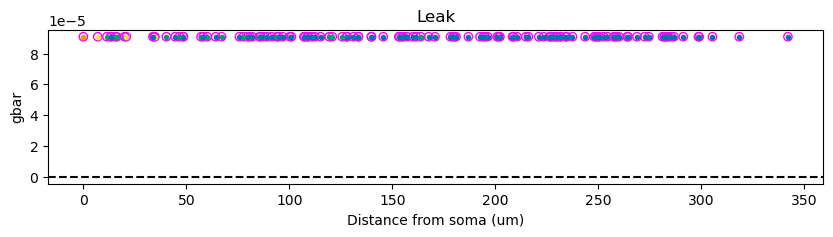

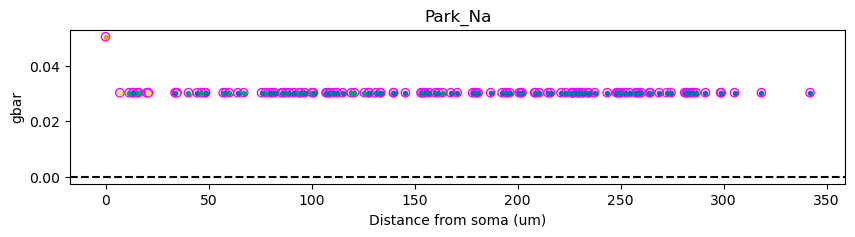

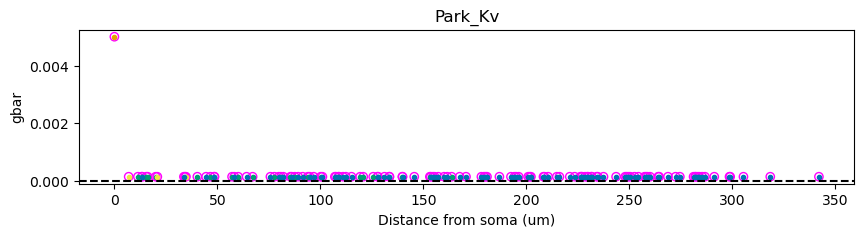

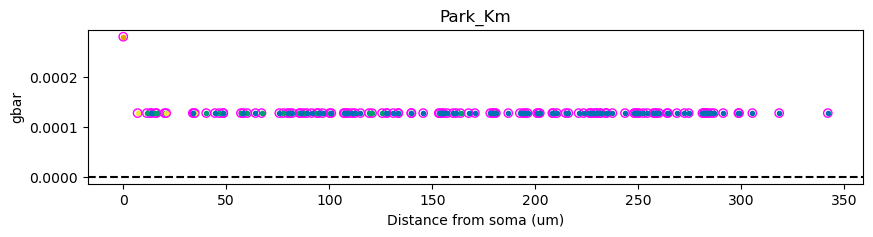

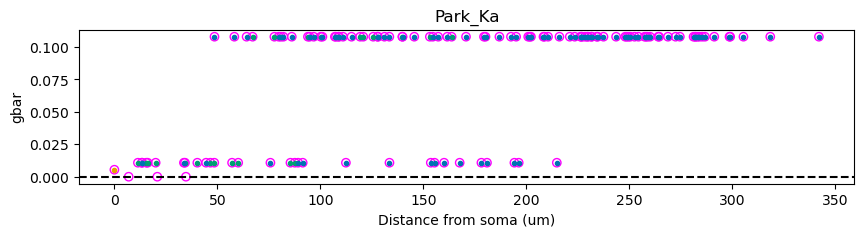

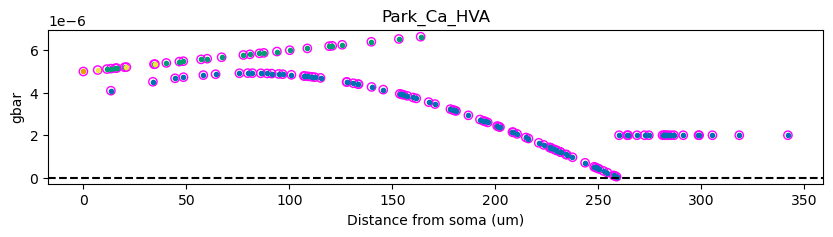

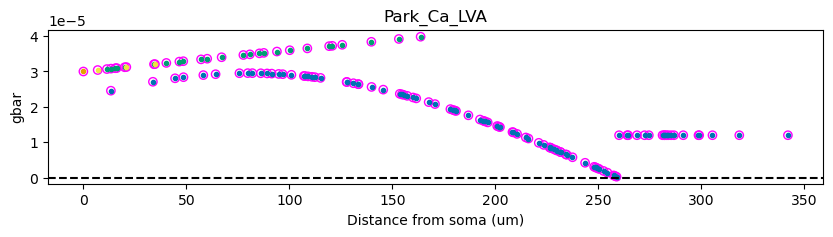

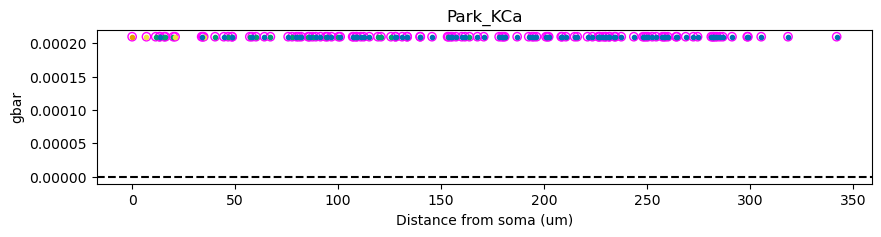

In [18]:
from utils import get_sec_type

types_to_colors = {'soma': '#E69F00', 'dend': '#019E73', 'apic': '#0072B2', 'axon': '#F0E442'}
all_distances = [model.cell.distance_from_soma(seg) for sec in model.cell.all for seg in sec]
for ch in model.channels.values():
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 2)
    true_values = [getattr(seg, f'gbar_{ch.suffix}') for sec in model.cell.all for seg in sec]
    ax.scatter(all_distances, true_values, marker='o', facecolor='None', edgecolor='magenta')
    for group in ch.groups:
        distances = [model.cell.distance_from_soma(seg) for seg in group.segments]
        types = [get_sec_type(seg.sec) for seg in group.segments]
        values = [group.distribution(dist) for dist in distances]
        for (dist, val), _type in zip(zip(distances, values), types):
            ax.plot(dist, val, '.', color=types_to_colors[_type])
        
    ax.set_title(ch.name)
    ax.set_xlabel('Distance from soma (um)')
    ax.set_ylabel('gbar')
    plt.axhline(y=0, color='k', linestyle='--')

## Equilibrium potentials

We might also want to update the values of equilibrium potentials for the present ions.

In [19]:
model.equilibrium_potentials = {'na': 60, 'k': -80, 'ca': 140, '_leak': -79}
for key, value in model.equilibrium_potentials.items():
    model.update_e(key, value);

In [21]:
for sec in model.cell.all:
    sec.Ra = 100

# Simulation

## Adding iclamps

To test our model, we'll run a simple simulation. We'll add a current clamp with an amplitude of 150 pA (0.15 nA).

In [22]:
model.add_iclamp(model.cell.soma[0](0.5), amp=0.15, delay=100, dur=800)

INFO       - model.py - add_iclamp : Added IClamp at <model.cells.Cell object at 0x7f240a40fed0>.soma[0](0.5).


## The `Simulator` class

To run a simulation, we'll use the `Simulator` class accessible as the model's attribute. We need to add a recording to the soma segment. We'll also specify simulation parameters as attributes of this class. Finally, we'll use the `run` method and pass to it the duration of the simulation in ms.

In [23]:
model.simulator.add_recording(model.cell.soma[0](0.5))

DEBUG      - cells.py - add_recording : Added recording for v at <model.cells.Cell object at 0x7f240a40fed0>.soma[0](0.5).


In [24]:
model.simulator.dt = 0.025
model.simulator.v_init = -79
model.simulator.celsius = 37

In [25]:
ts, vs, _ = model.simulator.run(1000) #ms

We can plot the result of the simulation

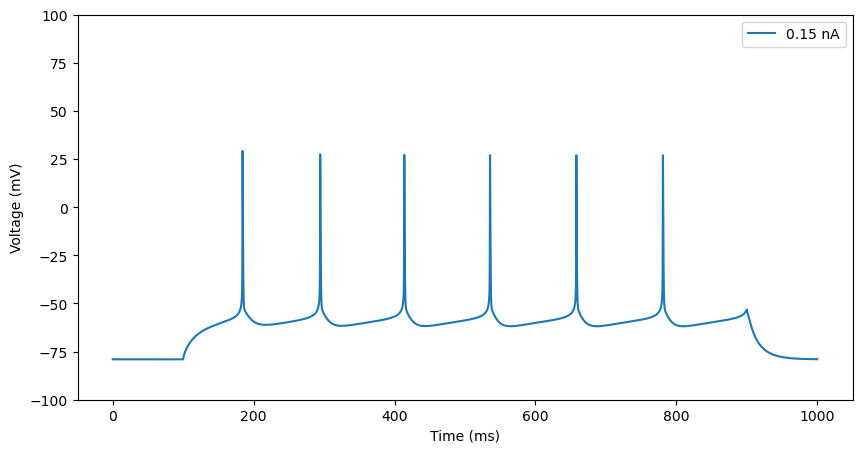

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(ts[0], vs[0], label=f'0.15 nA');
plt.ylim([-100, 100])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()

# Export the model state as JSON

Finally, we can export the defined parameters (excluding the stimuli) as a JSON file. We can further use this file to visualize the model in the DendroTweaks GUI.

In [27]:
# model.to_json('app/static/data/Park_2019_ephys.json')